In [82]:
##########################################
# Question 1                             #
##########################################

In [83]:
##########################################
# Fama French 3 Factors                  #
# Qingyi (Freda) Song Drechsler          #
# Date: April 2018                       #
# Updated: June 2020                     #
##########################################

import pandas as pd
import numpy as np
import datetime as dt
import wrds
#import psycopg2 
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
import warnings

In [84]:
###################
# Connect to WRDS #
###################
conn=wrds.Connection()

Loading library list...
Done


In [85]:
###################
# Compustat Block #
###################
comp = conn.raw_sql("""
                    select gvkey, datadate, at, pstkl, txditc,
                    pstkrv, seq, pstk
                    from comp.funda
                    where indfmt='INDL' 
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    and datadate >= '01/01/1925'
                    """, date_cols=['datadate'])

comp['year']=comp['datadate'].dt.year

In [86]:
# create preferrerd stock
comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])
comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps'])
comp['txditc']=comp['txditc'].fillna(0)

In [87]:
# create book equity
comp['be']=comp['seq']+comp['txditc']-comp['ps']
comp['be']=np.where(comp['be']>0, comp['be'], np.nan)

In [88]:
# number of years in Compustat
comp=comp.sort_values(by=['gvkey','datadate'])
comp['count']=comp.groupby(['gvkey']).cumcount()

comp=comp[['gvkey','datadate','year','be','count']]

In [89]:
###################
# CRSP Block      #
###################
# sql similar to crspmerge macro
crsp_m = conn.raw_sql("""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
                      a.ret, a.retx, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1924' and '12/31/2023'
                      and b.exchcd between 1 and 3
                      """, date_cols=['date']) 

# change variable format to int
crsp_m[['permco','permno','shrcd','exchcd']]=crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

# Line up date to be end of month
crsp_m['jdate']=crsp_m['date']+MonthEnd(0)

In [90]:
# add delisting return
dlret = conn.raw_sql("""
                     select permno, dlret, dlstdt 
                     from crsp.msedelist
                     """, date_cols=['dlstdt'])

dlret.permno=dlret.permno.astype(int)
dlret['jdate']=dlret['dlstdt']+MonthEnd(0)

crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])
crsp['dlret']=crsp['dlret'].fillna(0)
crsp['ret']=crsp['ret'].fillna(0)

# retadj factors in the delisting returns
crsp['retadj']=(1+crsp['ret'])*(1+crsp['dlret'])-1

# calculate market equity
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
crsp=crsp.drop(['dlret','dlstdt','prc','shrout'], axis=1)
crsp=crsp.sort_values(by=['jdate','permco','me'])

In [91]:
### Aggregate Market Cap ###
# sum of me across different permno belonging to same permco a given date
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()

# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index()

# join by jdate/maxme to find the permno
crsp1=pd.merge(crsp, crsp_maxme, how='inner', on=['jdate','permco','me'])

# drop me column and replace with the sum me
crsp1=crsp1.drop(['me'], axis=1)

# join with sum of me to get the correct market cap info
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco'])

# sort by permno and date and also drop duplicates
crsp2=crsp2.sort_values(by=['permno','jdate']).drop_duplicates()


In [92]:
# keep December market cap
crsp2['year']=crsp2['jdate'].dt.year
crsp2['month']=crsp2['jdate'].dt.month
decme=crsp2[crsp2['month']==12]
decme=decme[['permno','date','jdate','me','year']].rename(columns={'me':'dec_me'})

### July to June dates
crsp2['ffdate']=crsp2['jdate']+MonthEnd(-6)
crsp2['ffyear']=crsp2['ffdate'].dt.year
crsp2['ffmonth']=crsp2['ffdate'].dt.month
crsp2['1+retx']=1+crsp2['retx']
crsp2=crsp2.sort_values(by=['permno','date'])

In [93]:
# cumret by stock
crsp2['cumretx']=crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()

# lag cumret
crsp2['lcumretx']=crsp2.groupby(['permno'])['cumretx'].shift(1)

# lag market cap
crsp2['lme']=crsp2.groupby(['permno'])['me'].shift(1)

# if first permno then use me/(1+retx) to replace the missing value
crsp2['count']=crsp2.groupby(['permno']).cumcount()
crsp2['lme']=np.where(crsp2['count']==0, crsp2['me']/crsp2['1+retx'], crsp2['lme'])

# baseline me
mebase=crsp2[crsp2['ffmonth']==1][['permno','ffyear', 'lme']].rename(columns={'lme':'mebase'})

# merge result back together
crsp3=pd.merge(crsp2, mebase, how='left', on=['permno','ffyear'])
crsp3['wt']=np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])

decme['year']=decme['year']+1
decme=decme[['permno','year','dec_me']]

In [94]:
# Info as of June
crsp3_jun = crsp3[crsp3['month']==6]

crsp_jun = pd.merge(crsp3_jun, decme, how='inner', on=['permno','year'])
crsp_jun=crsp_jun[['permno','date', 'jdate', 'shrcd','exchcd','retadj','me','wt','cumretx','mebase','lme','dec_me']]
crsp_jun=crsp_jun.sort_values(by=['permno','jdate']).drop_duplicates()

In [95]:
#######################
# CCM Block           #
#######################
ccm=conn.raw_sql("""
                  select gvkey, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """, date_cols=['linkdt', 'linkenddt'])

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

ccm1=pd.merge(comp[['gvkey','datadate','be', 'count']],ccm,how='left',on=['gvkey'])
ccm1['yearend']=ccm1['datadate']+YearEnd(0)
ccm1['jdate']=ccm1['yearend']+MonthEnd(6)

In [96]:
# set link date bounds
ccm2=ccm1[(ccm1['jdate']>=ccm1['linkdt'])&(ccm1['jdate']<=ccm1['linkenddt'])]
ccm2=ccm2[['gvkey','permno','datadate','yearend', 'jdate','be', 'count']]

In [97]:
# Get all the unique stock identifiers from the CCM book equity dataframe
unique_permno = list(ccm2['permno'].unique())

# Create a dictionary which will match the unique stock permno to the stock's gvkey
# This will be used to merge this CCM dataframe with the historical FF dataframe created from the code below
permno_gvkey = {}

# Get the corresponding gvkey for each stock identifier and add to dictionary
for i in range(0, len(unique_permno)):
    temp = ccm2.loc[ccm2['permno'] == unique_permno[i], 'gvkey']
    if not temp.empty:
        gvkey = temp.iloc[0]
        permno_gvkey[unique_permno[i]] = gvkey
        
# Save this dictionary as a .npy file which can be merged with the historical FF dataframe
# This allows us to create a historical FF dataframe which has both permno and gvkey for each stock and makes it possible to merge
# The permno_gvkey_dictionary.npy will be read by the cleaning.ipynb as part of the processing of the historical book equity data from Ken French website
np.save('permno_gvkey_dictionary.npy', permno_gvkey)

In [98]:
#######################
# Read in the cleaned dataset containing the historical data from 1926, with gvkey column corresponding to each firm's permno
# This cleaned dataset was created from the cleaning.ipynb code, this code was intentionally separated from this file to separate the processes and simplify the code
# By reading in a processed dataframe for historical book equity from 1926, this makes the code easier to follow and allows readers to examine the cleaning code if interested
#######################

historical_ff_data_with_gvkey = pd.read_csv("DFF_BE_With_Nonindust_Cleaned_with_gvkey.csv")

# Remove index column
historical_ff_data_with_gvkey = historical_ff_data_with_gvkey.drop('Unnamed: 0', axis = 1)

# Convert date columns to Pandas datetime format
historical_ff_data_with_gvkey['datadate'] = pd.to_datetime(historical_ff_data_with_gvkey['datadate'])
historical_ff_data_with_gvkey['yearend'] = pd.to_datetime(historical_ff_data_with_gvkey['yearend'])
historical_ff_data_with_gvkey['jdate'] = pd.to_datetime(historical_ff_data_with_gvkey['jdate'])

In [99]:
# Merge the CCM dataset with the historical FF dataset using the gvkey and permno as common identifiers

ccm2_merged = pd.concat([historical_ff_data_with_gvkey, ccm2], ignore_index=True, axis=0)
ccm2_merged = ccm2_merged.sort_values(by=['permno','jdate']).drop_duplicates()

In [100]:
# link comp and crsp
ccm_jun=pd.merge(crsp_jun, ccm2_merged, how='inner', on=['permno', 'jdate'])
ccm_jun['beme']=ccm_jun['be']*1000/ccm_jun['dec_me']

In [101]:
warnings.filterwarnings('ignore')

# select NYSE stocks for bucket breakdown
# exchcd = 1 and positive beme and positive me and shrcd in (10,11) and at least 2 years in comp
nyse=ccm_jun[(ccm_jun['exchcd']==1) & (ccm_jun['beme']>0) & (ccm_jun['me']>0) & \
            ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))]

# size breakdown
nyse_sz=nyse.groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})

# beme breakdown
nyse_bm=nyse.groupby(['jdate'])['beme'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_bm=nyse_bm[['jdate','30%','70%']].rename(columns={'30%':'bm30', '70%':'bm70'})

nyse_breaks = pd.merge(nyse_sz, nyse_bm, how='inner', on=['jdate'])

# join back size and beme breakdown
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])

In [102]:
# Compute the mean BM breakpoints for the 30th and 70th percentiles grouping by each month

bm70_time_series = ccm1_jun.groupby('jdate')['bm70'].mean()
bm30_time_series = ccm1_jun.groupby('jdate')['bm30'].mean()

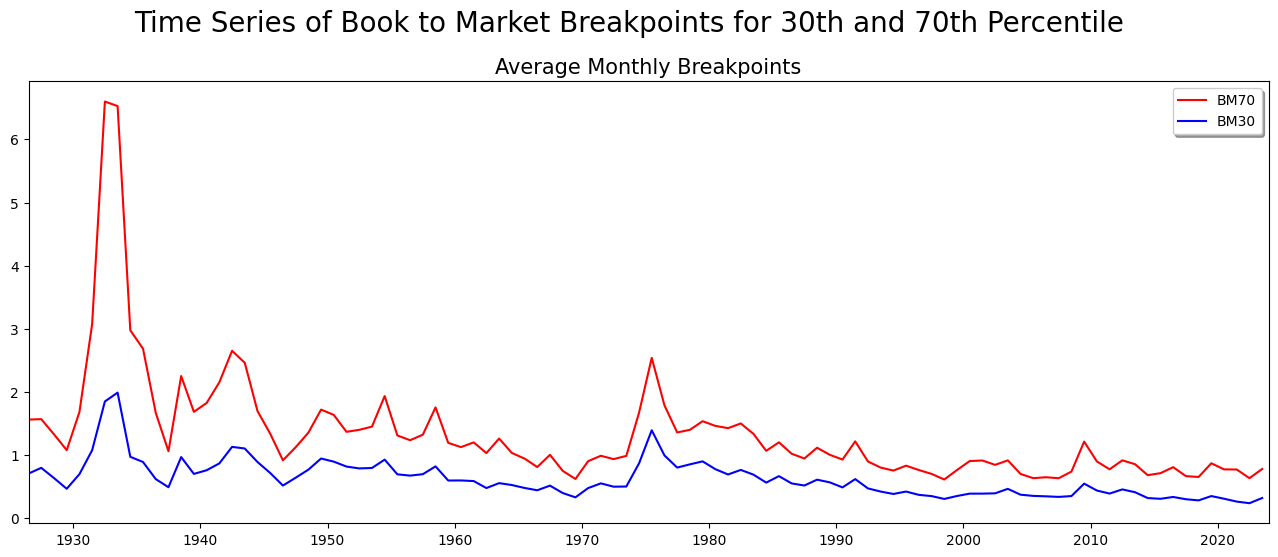

In [103]:
# Plot the mean BM breakpoints over time for the 30th and 70th percentiles to analyse how they vary

plt.figure(figsize=(16,12))
plt.suptitle('Time Series of Book to Market Breakpoints for 30th and 70th Percentile', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('Average Monthly Breakpoints', fontsize=15)
ax1.set_xlim([dt.datetime(1926,7,1), dt.datetime(2023,12,31)])
ax1.plot(bm70_time_series, 'r-', bm30_time_series, 'b-')
ax1.legend(('BM70','BM30'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

In [104]:
# Add in the Fama French breakpoints for comparison with the breakpoints computed above

ff_breakpoints = pd.read_csv("BE-ME_Breakpoints.csv", skiprows=3, header=None)
ff_breakpoints.drop(ff_breakpoints.tail(1).index,inplace=True)

# Label each column according to the percentile to accurately retrieve the 30th (bm30) and 70th (bm70) percentiles
ff_breakpoints = ff_breakpoints.rename({0: 'year', 3: 'bm5', 4: 'bm10', 5: 'bm15', 6: 'bm20', 7: 'bm25', 8: 'bm30', 9: 'bm35', 10: 'bm40',
                                       11: 'bm45', 12: 'bm50', 13: 'bm55', 14: 'bm60', 15: 'bm65', 16: 'bm70', 17: 'bm75', 18: 'bm80',
                                       19: 'bm85', 20: 'bm90', 21: 'bm95', 22: 'bm100'}, axis='columns')

# Match the date column values with the last day of June in each year
ff_breakpoints['year'] = pd.to_datetime(ff_breakpoints['year']) + pd.DateOffset(months=6) - pd.DateOffset(1)

# Set the date as the index for comparison of breakpoints
ff_breakpoints.set_index('year', inplace=True)

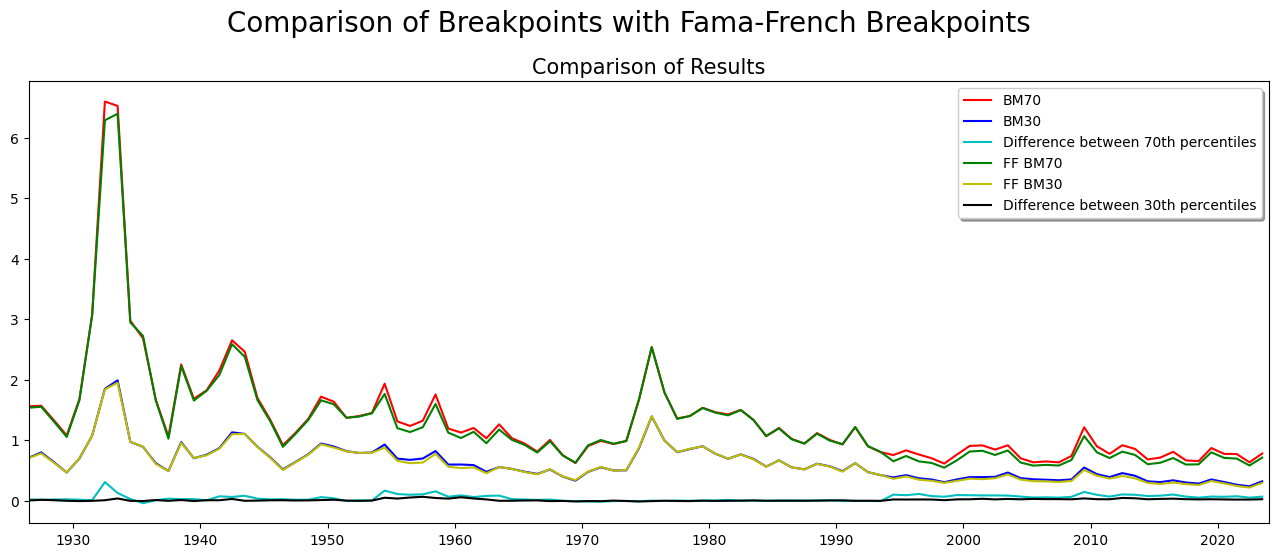

In [105]:
# Plot our mean BM breakpoints and the FF breakpoints for the 30th and 70th percentiles as a comparison

plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Breakpoints with Fama-French Breakpoints', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('Comparison of Results', fontsize=15)
ax1.set_xlim([dt.datetime(1926,7,1), dt.datetime(2023,12,31)])

# Get the difference between the computed breakpoints and the ff breakpoints and plot the difference along the time series
ax1.plot(bm70_time_series, 'r-', bm30_time_series, 'b-', bm70_time_series - ff_breakpoints['bm70'], 'c-', ff_breakpoints['bm70'], 'g-', ff_breakpoints['bm30'], 'y-', bm30_time_series - ff_breakpoints['bm30'], 'k-')
ax1.legend(('BM70','BM30', 'Difference between 70th percentiles', 'FF BM70', 'FF BM30', 'Difference between 30th percentiles'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

In [106]:
##########################################
# Question 2                             #
##########################################

In [107]:
# function to assign sz and bm bucket
def sz_bucket(row):
    if row['me']==np.nan:
        value=''
    elif row['me']<=row['sizemedn']:
        value='S'
    else:
        value='B'
    return value

def bm_bucket(row):
    if 0<=row['beme']<=row['bm30']:
        value = 'L'
    elif row['beme']<=row['bm70']:
        value='M'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=''
    return value


In [108]:
# assign size portfolio
ccm1_jun['szport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(sz_bucket, axis=1), '')

# assign book-to-market portfolio
ccm1_jun['bmport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(bm_bucket, axis=1), '')
ccm1_jun.sort_values(by = 'jdate').head(500)

# create positivebmeme and nonmissport variable
ccm1_jun['posbm']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), 1, 0)
ccm1_jun['nonmissport']=np.where((ccm1_jun['bmport']!=''), 1, 0)

In [109]:

# store portfolio assignment as of June
june=ccm1_jun[['permno','date', 'jdate', 'bmport','szport','posbm','nonmissport']]
june['ffyear']=june['jdate'].dt.year

# merge back with monthly records
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj','me','wt','cumretx','ffyear','jdate']]
ccm3=pd.merge(crsp3, 
        june[['permno','ffyear','szport','bmport','posbm','nonmissport']], how='left', on=['permno','ffyear'])

# keeping only records that meet the criteria
ccm5=ccm3[(ccm3['wt']>0) &
          ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]

In [110]:
# Get the standard deviations of the returns each month

stdev_monthly_returns = ccm5.groupby('date')['retadj'].std()

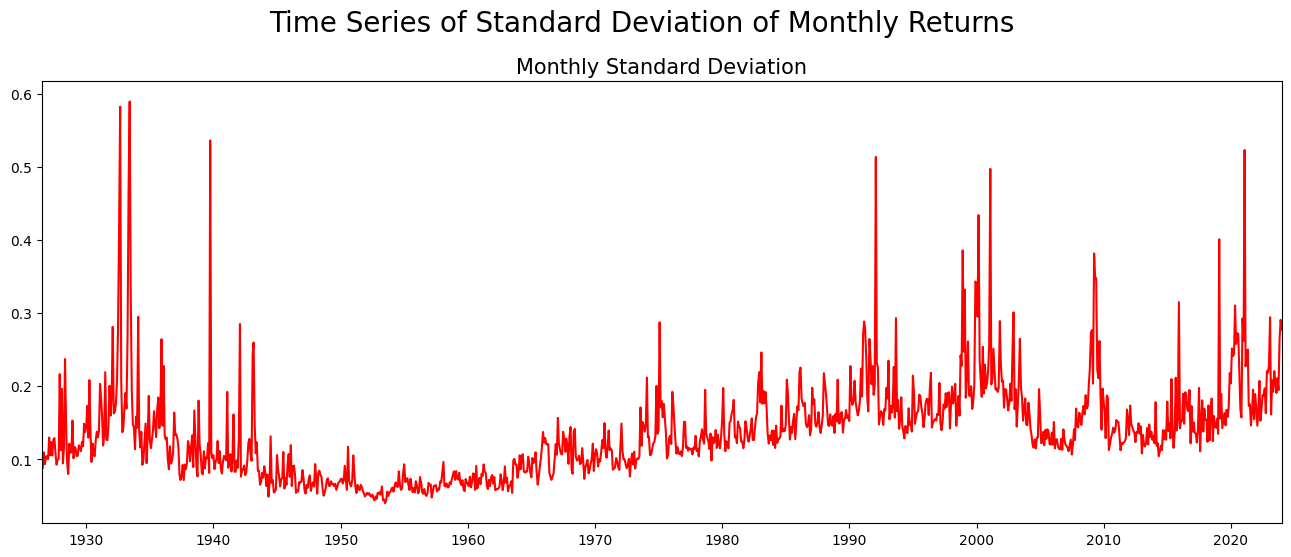

In [111]:
# Plot the standard deviations of the monthly returns over time

plt.figure(figsize=(16,12))
plt.suptitle('Time Series of Standard Deviation of Monthly Returns', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('Monthly Standard Deviation', fontsize=15)
ax1.set_xlim([dt.datetime(1926,7,1), dt.datetime(2023,12,31)])
ax1.plot(stdev_monthly_returns, 'r-')

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

In [112]:
##########################################
# Question 3                             #
##########################################

In [113]:
############################
# Form Fama French Factors #
############################

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

In [114]:

# value-weigthed return
vwret=ccm5.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret['sbport']=vwret['szport']+vwret['bmport']

# firm count
vwret_n=ccm5.groupby(['jdate','szport','bmport'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
vwret_n['sbport']=vwret_n['szport']+vwret_n['bmport']

# tranpose
ff_factors=vwret.pivot(index='jdate', columns='sbport', values='vwret').reset_index()
ff_nfirms=vwret_n.pivot(index='jdate', columns='sbport', values='n_firms').reset_index()


In [115]:
# create HML factors
ff_factors['WH']=(ff_factors['BH']+ff_factors['SH'])/2
ff_factors['WL']=(ff_factors['BL']+ff_factors['SL'])/2
ff_factors['WHML'] = ff_factors['WH']-ff_factors['WL']

ff_factors=ff_factors.rename(columns={'jdate':'date'})

# n firm count
ff_nfirms['H']=ff_nfirms['SH']+ff_nfirms['BH']
ff_nfirms['L']=ff_nfirms['SL']+ff_nfirms['BL']
ff_nfirms['HML']=ff_nfirms['H']+ff_nfirms['L']

ff_nfirms['TOTAL']=ff_nfirms['HML']
ff_nfirms=ff_nfirms.rename(columns={'jdate':'date'})

In [116]:
warnings.filterwarnings('ignore')

###################
# Compare With FF #
###################
_ff = conn.get_table(library='ff', table='factors_monthly')
_ff=_ff[['date','hml']]
_ff['date']=_ff['date']+MonthEnd(0)

# Filter ff_factors to include only dates that are present in _ff
ff_factors_filtered = ff_factors[ff_factors['date'].isin(_ff['date'])]

# Set 'date' column as index for both DataFrames
_ff.set_index('date', inplace=True)
ff_factors_filtered.set_index('date', inplace=True)

# Concatenate the DataFrames along the columns axis
_ffcomp = pd.concat([_ff, ff_factors_filtered[['WHML']]], axis=1, join='inner')

# Reset index to make 'date' a column again
_ffcomp.reset_index(inplace=True)

# Filter dates
_ffcomp70 = _ffcomp[_ffcomp['date'] >= pd.Timestamp('1970-01-01')]

# Convert Decimal objects to floats
_ffcomp70['hml'] = _ffcomp70['hml'].astype(float)
_ffcomp70['WHML'] = _ffcomp70['WHML'].astype(float)

# Replace infinite values with a large finite value
_ffcomp70.replace([np.inf, -np.inf], np.nan, inplace=True)
_ffcomp70.fillna(1e15, inplace=True)  # Replace with a large finite value

# Calculate Pearson correlation coefficient
correlation_coefficient, p_value = stats.pearsonr(_ffcomp70['hml'], _ffcomp70['WHML'])
print("Pearson correlation coefficient:", round(correlation_coefficient, 3))
print("P-value:", "{:.2f}".format(p_value))

Pearson correlation coefficient: 0.984
P-value: 0.00


In [117]:
# Check the last observation should be the final day of 2023 (2023-12-31)

_ffcomp.tail(2)

,date,hml,WHML
1168,2023-11-30,0.016400,-0.000507
1169,2023-12-31,0.049300,0.026396


In [118]:
# Set the date as the index for comparison purposes and check the first observation should be the last day of July in 1926 (1926-07-31)

_ffcomp.date = pd.to_datetime(_ffcomp.date)
_ffcomp.set_index('date', inplace=True)
_ffcomp.head(5)

,hml,WHML
date,,
1926-07-31,-0.024300,-0.030570
1926-08-31,0.038200,0.041262
1926-09-30,0.001300,0.000473
1926-10-31,0.007000,-0.000859
1926-11-30,-0.005100,-0.002417


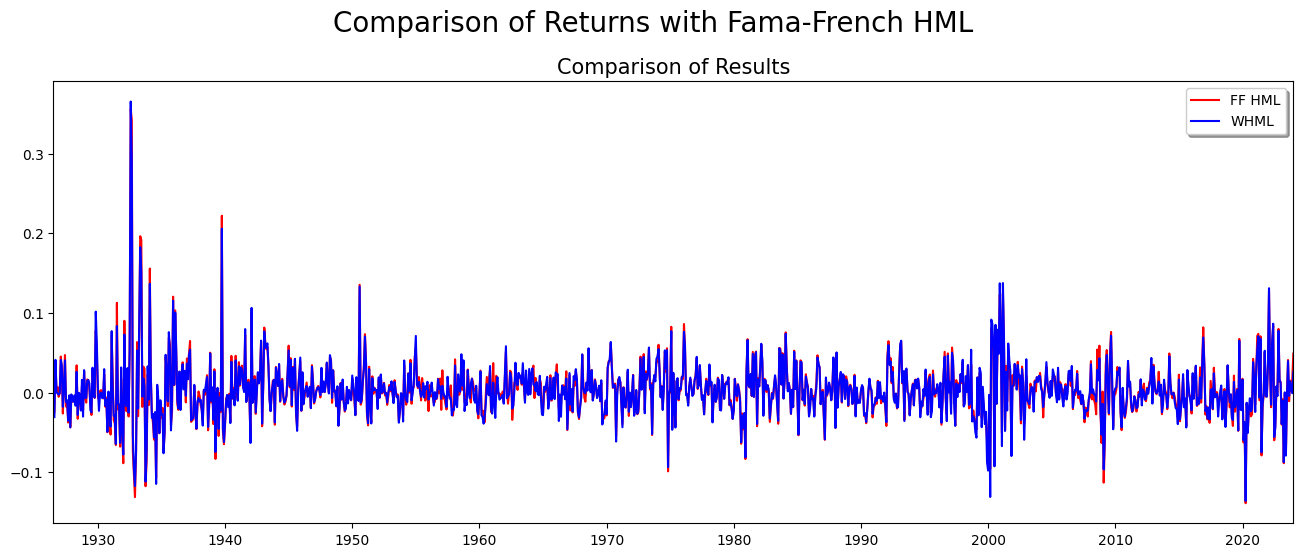

In [119]:
# Plot the comparison of monthly returns of the factors calculated above (WHML) with the Fama French factors (FF HML)

plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Returns with Fama-French HML', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('Comparison of Results', fontsize=15)
ax1.set_xlim([dt.datetime(1926,7,1), dt.datetime(2023,12,31)])
ax1.plot(_ffcomp['hml'], 'r-', _ffcomp['WHML'], 'b-')
ax1.legend(('FF HML','WHML'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

In [120]:
# Fill the NA values with zeroes for the purpose of calculating cumulative returns over time

_ffcomp["WHML"] = _ffcomp["WHML"].fillna(0)

In [121]:
# Calculate the cumulative returns for our HML factor and the Fama French HML factor

_ffcomp["cum_hml"] = np.cumprod(1 + _ffcomp['hml'].values) - 1
_ffcomp["cum_WHML"] = np.cumprod(1 + _ffcomp['WHML'].values) - 1

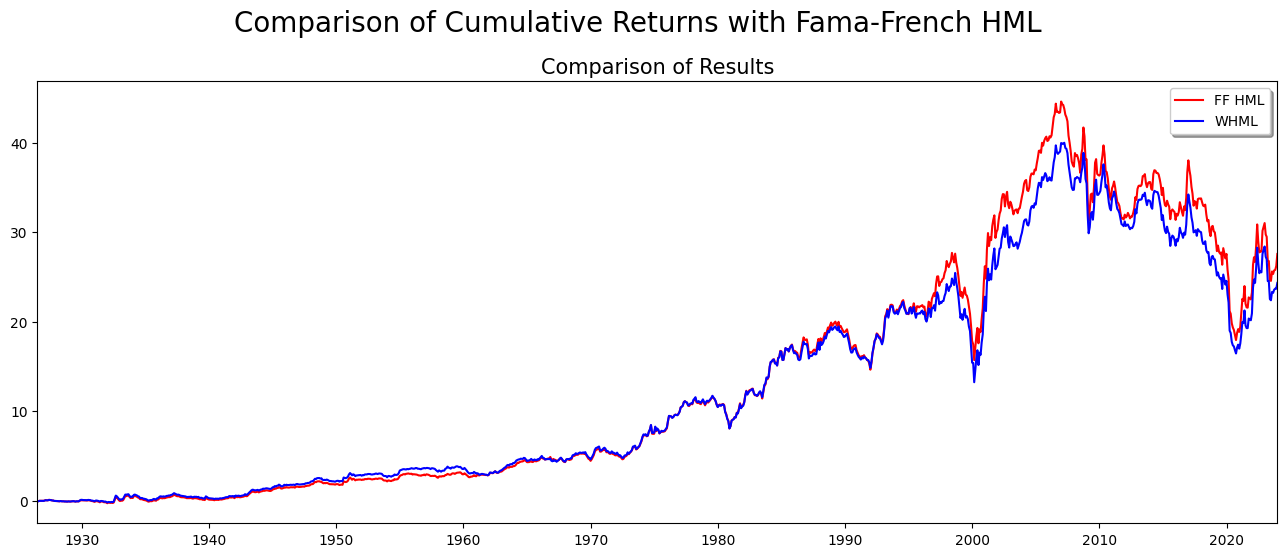

In [122]:
# Plot the comparison of cumulative returns of the factors calculated above (WHML) with the Fama French factors (FF HML)

plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Cumulative Returns with Fama-French HML', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('Comparison of Results', fontsize=15)
ax1.set_xlim([dt.datetime(1926,7,1), dt.datetime(2023,12,31)])
ax1.plot(_ffcomp['cum_hml'], 'r-', _ffcomp['cum_WHML'], 'b-')
ax1.legend(('FF HML','WHML'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

In [126]:
##########################################
# Question 4                             #
##########################################

In [123]:
# Input the JKP US book to market factors for equal weighted, value weighted and capped value weighted respectively below

jkp_factor_equal_weighted = pd.read_csv('[usa]_[be_me]_[monthly]_[ew].csv')
jkp_factor_value_weighted = pd.read_csv('[usa]_[be_me]_[monthly]_[vw].csv')
jkp_factor_capped_value_weighted = pd.read_csv('[usa]_[be_me]_[monthly]_[vw_cap].csv')

In [124]:
# Convert the date columns to datetime format and set the date as the index for the JKP datasets

jkp_factor_equal_weighted['date'] = pd.to_datetime(jkp_factor_equal_weighted['date'])
jkp_factor_value_weighted['date'] = pd.to_datetime(jkp_factor_value_weighted['date'])
jkp_factor_capped_value_weighted['date'] = pd.to_datetime(jkp_factor_capped_value_weighted['date'])

jkp_factor_equal_weighted.set_index('date', inplace = True)
jkp_factor_value_weighted.set_index('date', inplace = True)
jkp_factor_capped_value_weighted.set_index('date', inplace = True)

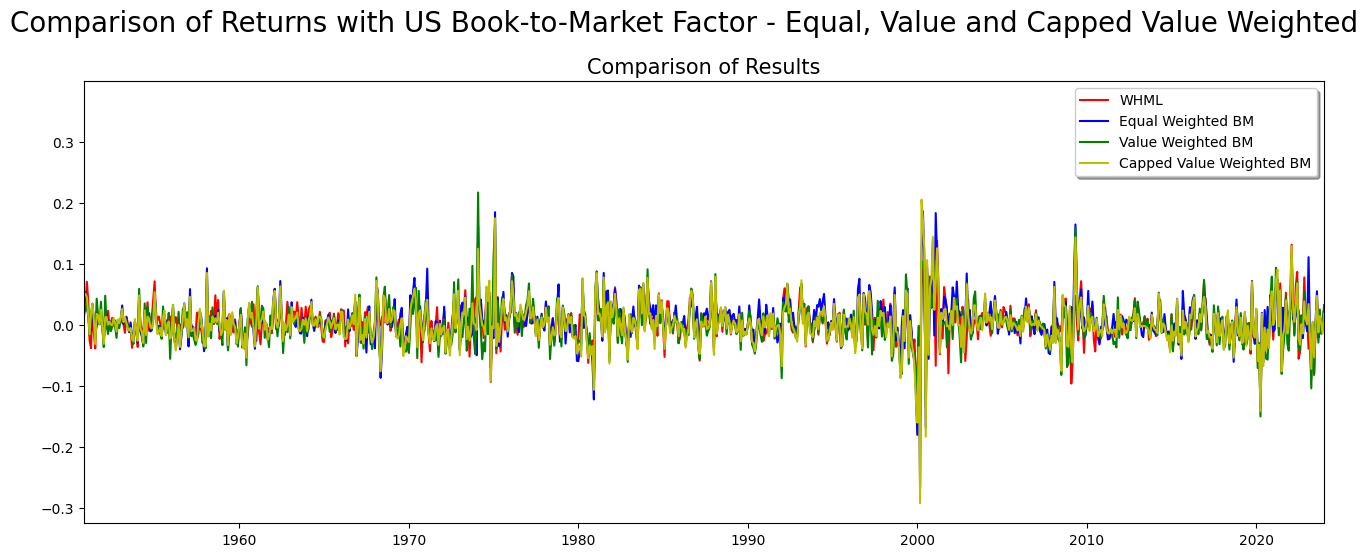

In [125]:
# Plot the comparison of monthly returns for our factor (WHML) with the JKP factors (Equal Weighted BM, Value Weighted BM, Capped Value Weighted BM)

plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Returns with US Book-to-Market Factor - Equal, Value and Capped Value Weighted', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('Comparison of Results', fontsize=15)
ax1.set_xlim([dt.datetime(1950,11,1), dt.datetime(2023,12,31)])
ax1.plot(_ffcomp['WHML'], 'r-', jkp_factor_equal_weighted['ret'], 'b-', jkp_factor_value_weighted['ret'], 'g-', jkp_factor_capped_value_weighted['ret'], 'y-')
ax1.legend(('WHML','Equal Weighted BM', 'Value Weighted BM', 'Capped Value Weighted BM'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

In [127]:
# Calculate the cumulative returns for the JKP HML factors

jkp_factor_equal_weighted['cum_ret'] = np.cumprod(1 + jkp_factor_equal_weighted['ret'].values) - 1
jkp_factor_value_weighted['cum_ret'] = np.cumprod(1 + jkp_factor_value_weighted['ret'].values) - 1
jkp_factor_capped_value_weighted['cum_ret'] = np.cumprod(1 + jkp_factor_capped_value_weighted['ret'].values) - 1

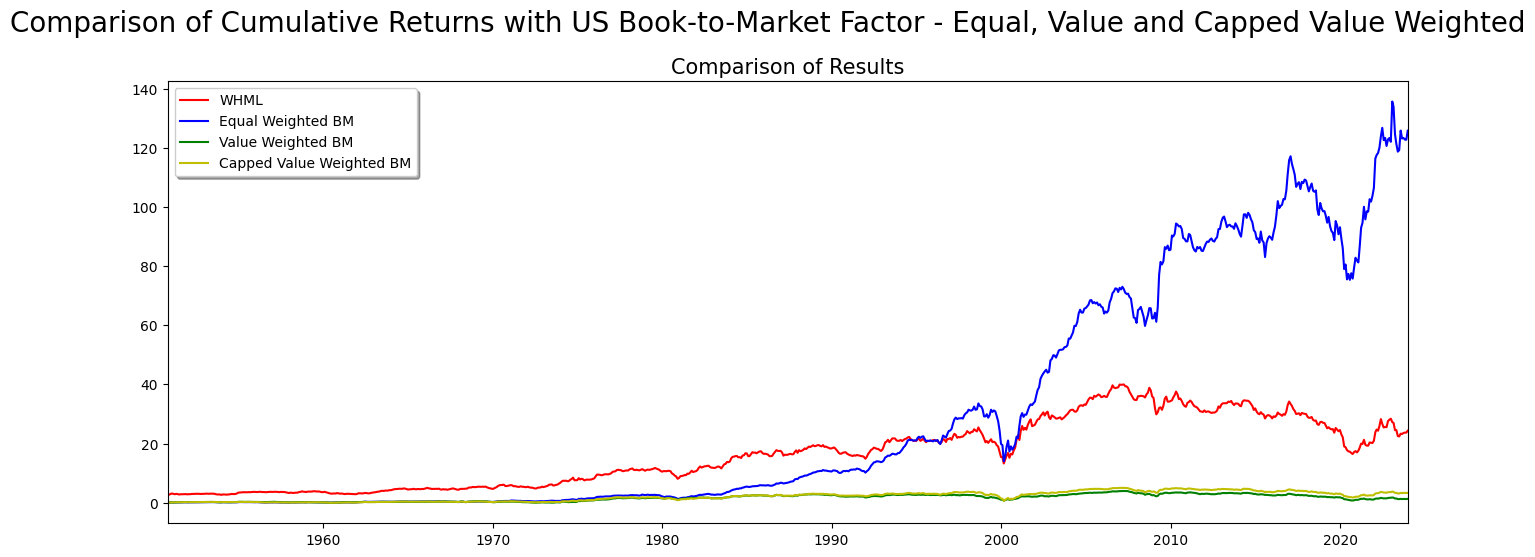

In [128]:
# Plot the comparison of cumulative returns for our factor (WHML) with the JKP factors (Equal Weighted BM, Value Weighted BM, Capped Value Weighted BM)

plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Cumulative Returns with US Book-to-Market Factor - Equal, Value and Capped Value Weighted', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('Comparison of Results', fontsize=15)
ax1.set_xlim([dt.datetime(1950,11,1), dt.datetime(2023,12,31)])
ax1.plot(_ffcomp['cum_WHML'], 'r-', jkp_factor_equal_weighted['cum_ret'], 'b-', jkp_factor_value_weighted['cum_ret'], 'g-', jkp_factor_capped_value_weighted['cum_ret'], 'y-')
ax1.legend(('WHML','Equal Weighted BM', 'Value Weighted BM', 'Capped Value Weighted BM'), loc='upper left', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

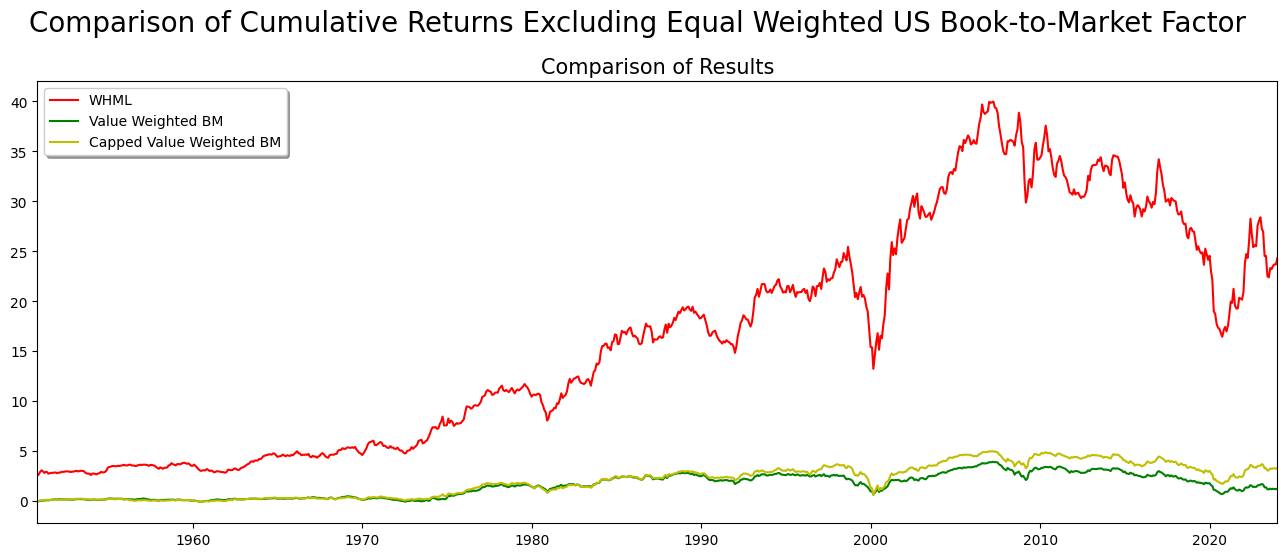

In [129]:
# Plot the comparison of cumulative returns for our factor (WHML) with the JKP factors (Value Weighted BM, Capped Value Weighted BM)
# But in this plot, we exclude the JKP equal-weighted HML factors which had previously affected the results presented due to its excessively large cumulative returns
# This plot visualises the cumulative returns for the value-weighted and capped-value-weighted JKP factors on a clearer vertical axis scale

plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Cumulative Returns Excluding Equal Weighted US Book-to-Market Factor', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('Comparison of Results', fontsize=15)
ax1.set_xlim([dt.datetime(1950,11,1), dt.datetime(2023,12,31)])
ax1.plot(_ffcomp['cum_WHML'], 'r-', jkp_factor_value_weighted['cum_ret'], 'g-', jkp_factor_capped_value_weighted['cum_ret'], 'y-')
ax1.legend(('WHML', 'Value Weighted BM', 'Capped Value Weighted BM'), loc='upper left', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()